# Fuzzy logic function implementation

In [1]:
# imported modules/libraries:
import numpy as np, pandas as pd, skfuzzy as fuzz, warnings, matplotlib.pyplot as plt
from skfuzzy import control as ctrl

# ignore warnings:
warnings.filterwarnings("ignore", category = UserWarning)

# show all rows and columns setup:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# function to load and read input file:
def open(file_name, format):
    """
    Purpose:
    Load and read input file in .csv or .xlsx format

    Parameters:
    1. file_name (str): the name of the input file without extension
    2. format (int): the format of the input file
    - 0: for .csv format
    - 1: for .xlsx format

    Returns:
    pandas.DataFrame => a dataframe containing the data read from the input file (.csv/.xlsx)
    """
    # check and load defined input file:
    if format == 0: return pd.read_csv(f"{file_name}.csv")
        
    elif format == 1: return pd.read_excel(f"{file_name}.xlsx")
        
    else: print("Either wrong file_name or format or both!")

In [3]:
# function to add one additional column for later
# and to filter out NaN rows for status/trend and peak
def modify_df():
    """
    Purpose:
    Function to modify a dataframe by adding one additional column for later use
    and filtering out rows containing NaN values in 'Status', 'Trend', and 'Peak' columns

    Parameters:
    None

    Returns:
    pandas.DataFrame: modified dataframe with "rules_passed" column added and NaN rows filtered out
    """

    
    # *****************************************
    # call open(file_name, format)
    # change this only once:
    df = open("240318_Test", 1)
    # *****************************************
    
    
    # add "rules_passed" empty column:
    df["rules_passed"] = ''

    # filter out rows containing empty values:
    filtered_df = (
        df.dropna(subset = ["Status", "Trend", "Peak"]))

    return filtered_df

# Test I

In [4]:
# calling open(file_name, format)
# and modify() functions:
df = modify_df()

# check first 5 rows of data:
df.head()

,Region,ISO3,Month_year,Status,Trend,Peak,Indicator_name,rules_passed
14,R_ASIA,AFG,2021-03-01,357142.857143,0.0,0.000000,Extreme humanitarian conditions - Level 5,
15,R_ASIA,AFG,2021-04-01,428571.428571,0.0,0.000000,Extreme humanitarian conditions - Level 5,
16,R_ASIA,AFG,2021-05-01,476190.476190,0.0,0.000000,Extreme humanitarian conditions - Level 5,
17,R_ASIA,AFG,2021-06-01,500000.000000,0.0,0.000000,Extreme humanitarian conditions - Level 5,
18,R_ASIA,AFG,2021-07-01,500000.000000,0.0,5494.505495,Extreme humanitarian conditions - Level 5,


In [5]:
# main function for input variables (status, trend and peak):
def antecedent(df_col, min_val = None, max_val = None, step_val = None):
    """
    Purpose:
    Creates an antecedent (input) fuzzy variable and membership function
    based on data from a dataframe => df and dataframe column => df_col

    Parameters:
    - Mandatory:
    1. df_col (str): the name of the column in the dataframe to use for
    creating the antecedent values (status, trend or peak)

    - Optional:
    1. min_val (float, optional): the minimum value of the antecedent variable
    - If not provided, the minimum value of the dataframe column will be used
    2. max_val (float, optional): the maximum value of the antecedent variable
    - If not provided, the maximum value of the dataframe column will be used
    3. step_val (float/int, optional): the step size for generating the range of the antecedent variable
    - If not provided, the step size will be automatically calculated based on the range.

    Returns:
    skfuzzy.control.antecedent.Antecedent => the antecedent fuzzy variable/function created using the specified parameters
    """
    # main setup:
    min = df[df_col].min() if min_val is None else min_val
    max = df[df_col].max() if max_val is None else max_val
    step = (max - min) / 100 if step_val is None else step_val
    var = df_col.lower()
    
    # variable setup:
    var = (
        ctrl.Antecedent(np.arange(min, max + step, step), var))

    # automatic function membership setup for => poor, average, good:
    var.automf(3)
    
    return var

In [6]:
# main function for output variables (pre, acute, protracted and post):
def consequent():
    """
    Purpose:
    Creates an consequent (output) fuzzy variable and membership function

    Parameters:
    None

    Returns:
    skfuzzy.control.Consequent => the consequent fuzzy variable/function created using custom values
    """

    # ************************************************************************
    # main setup:
    min = 0
    max = 100
    output_resolution = 100
    # ************************************************************************
    
    # setup variable:
    output = (
        ctrl.Consequent(np.linspace(min, max, output_resolution), "output"))


    # ************************************************************************
    # custom membership function setup for => pre, acute, protracted and post,
    # and this can be changed in the future if needed:
    output["pre"] = fuzz.trimf(output.universe, [min, 25, 50])
    output["acute"] = fuzz.trimf(output.universe, [25, 50, 75])
    output["protracted"] = fuzz.trimf(output.universe, [50, 75, 100])
    output["post"] = fuzz.trimf(output.universe, [75, 100, max])
    # ************************************************************************

    
    return output

# Test II

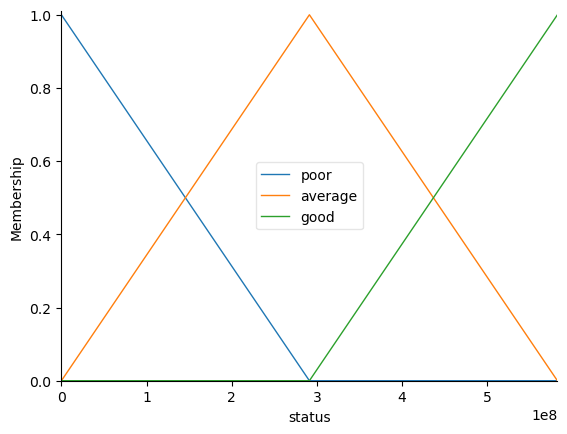

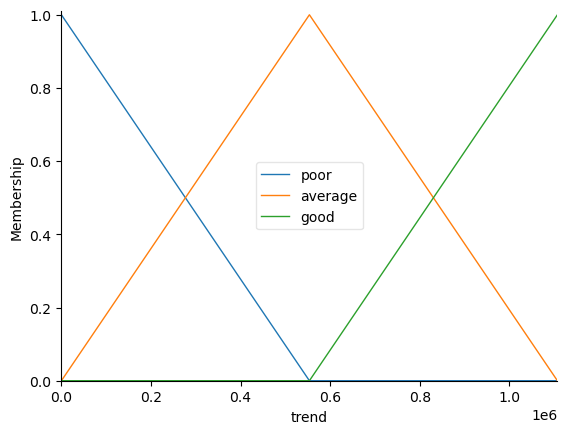

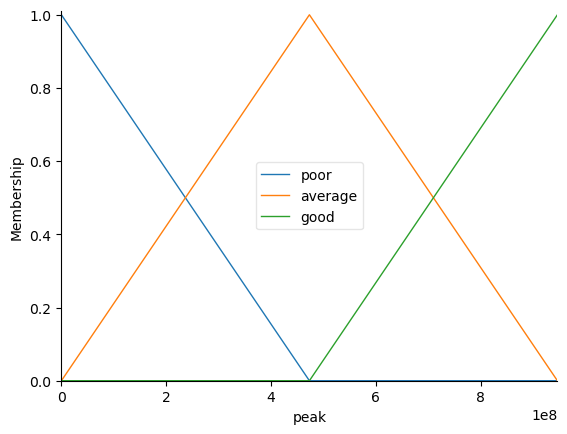

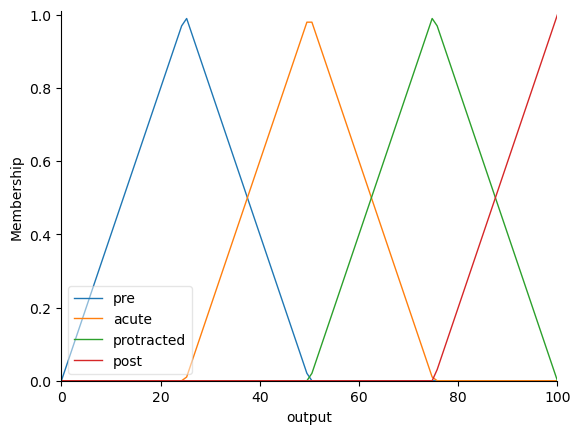

In [7]:
# calling antecedent(df_col, min_val = None, max_val = None, step_val = None)
# and consequent() functions:


# ************************************
# antecedent (input) from a df
# if there is a need to change
# the values do it here:
status = antecedent("Status")
trend = antecedent("Trend")
peak = antecedent("Peak")

# consequent (output)
# if there is a need to change values
# do that within the function itself:
output = consequent()

# ************************************


# variable instances:
status_view = status.view()
trend_view = trend.view()
peak_view = peak.view()
output_view = output.view()

# print one by one to check graphicaly membership functions,
# for all three input var/func and one output var/func:
if status_view is not None:
    print(status_view)
    
if trend_view is not None:
    print(trend_view)
    
if peak_view is not None:
    print(peak_view)
    
if output_view is not None:
    print(output_view)

In [8]:
# function for control system, applied for all rules:
def control_sys(rule_pre, rule_acute, rule_protracted, rule_post):
    """
    Purpose:
    Creation of a control system simulation instance which will be used afterwards
    It must be applied for all rules!
    
    Parameters:
    Not needed to be defined here (they will be called and activated within next function
    fully automatically) inside rule_x functions
    
    Returns:
    ctrl.ControlSystemSimulation => control instance of the object which will be used for rules
    """
    # control system simulator for specific rules and rule groups:
    control = ctrl.ControlSystem([rule_pre, rule_acute, rule_protracted, rule_post])
    main_control = ctrl.ControlSystemSimulation(control)
    
    return main_control

In [9]:
# function for the I rule:
def rule_one():
    """
    Purpose:
    Initiation and simulation for rule set (I rule)

    Parameters:
    None

    Returns:
    skfuzzy.control.ControlSystemSimulation => a control system simulation object initialized for rule I
    """

    
    # ************************************************************************************
    # rules setup
    # if there is a need to change the categories, do it here:
    rule_pre = ctrl.Rule(status["poor"] & trend["good"] & peak["poor"], output["pre"])
    rule_acute = ctrl.Rule(status["good"], output["acute"])
    rule_protracted = ctrl.Rule(peak["good"], output["protracted"])
    rule_post = ctrl.Rule(status["poor"] & trend["poor"] & peak["average"], output["post"])
    # ************************************************************************************
    

    # Control setup:
    main_control_one = control_sys(rule_pre, rule_acute, rule_protracted, rule_post)

    return main_control_one

In [10]:
# function for the II rule:
def rule_two():
    """
    Purpose:
    Initiation and simulation for rule set (II rule)

    Parameters:
    None

    Returns:
    skfuzzy.control.ControlSystemSimulation => a control system simulation object initialized for rule II
    """

    # *****************************************************************************************************
    # rules setup
    # if there is a need to change the categories, do it here:
    rule_pre = ctrl.Rule(status["poor"] & trend["good"] & peak["poor"], output["pre"])
    rule_acute = ctrl.Rule(status["good"] & trend["good"], output["acute"])
    rule_protracted = ctrl.Rule(status["good"] & peak["good"], output["protracted"])
    rule_post = ctrl.Rule(status["poor"] & trend["poor"] & (peak["poor"] | peak["average"]), output["post"])
    # *****************************************************************************************************

    
    # control setup: 
    main_control_two = control_sys(rule_pre, rule_acute, rule_protracted, rule_post)

    return main_control_two

In [11]:
# function for the III rule:
def rule_three():
    """
    Purpose:
    Initiation and simulation for rule set (III rule)

    Parameters:
    None

    Returns:
    skfuzzy.control.ControlSystemSimulation => a control system simulation object initialized for rule III
    """

    # *****************************************************************************************************
    # rules setup
    # if there is a need to change the categories, do it here:
    rule_pre = ctrl.Rule(status["poor"] & trend["good"] & peak["poor"], output["pre"])
    rule_acute = ctrl.Rule(status["good"] & trend["good"], output["acute"])
    rule_protracted = ctrl.Rule(status["good"] & peak["good"], output["protracted"])
    rule_post = ctrl.Rule(status["poor"] & trend["poor"] & (peak["poor"] | peak["average"]), output["post"])
    # *****************************************************************************************************

    
    # control setup: 
    main_control_three = control_sys(rule_pre, rule_acute, rule_protracted, rule_post)

    return main_control_three

In [12]:
# function for the IV rule:
def rule_four():
    """
    Purpose:
    Initiation and simulation for rule set (IV rule)

    Parameters:
    None

    Returns:
    skfuzzy.control.ControlSystemSimulation => a control system simulation object initialized for rule IV
    """

    
    # *********************************************************************************
    # rules setup
    # if there is a need to change the categories, do it here:
    rule_pre = ctrl.Rule(status["good"] & trend["good"], output["pre"])
    rule_acute = ctrl.Rule(status["good"], output["acute"])
    rule_protracted = ctrl.Rule(status["average"] & peak["good"], output["protracted"])
    rule_post = ctrl.Rule(status["poor"] & trend["poor"], output["post"])
    # *********************************************************************************

    
    # control setup: 
    main_control_four = control_sys(rule_pre, rule_acute, rule_protracted, rule_post)

    return main_control_four

# Test III

Output value: 87.37374617864036


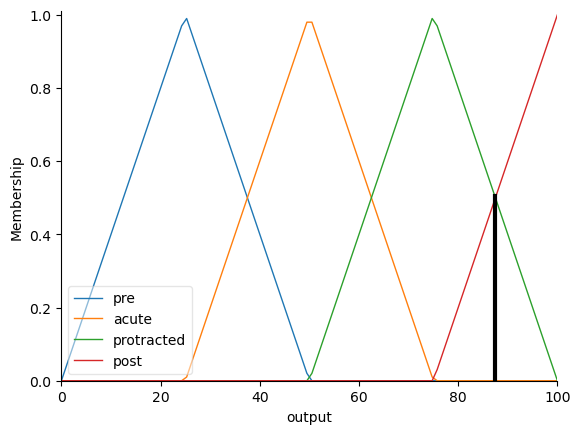

Output value: 91.66161795047296


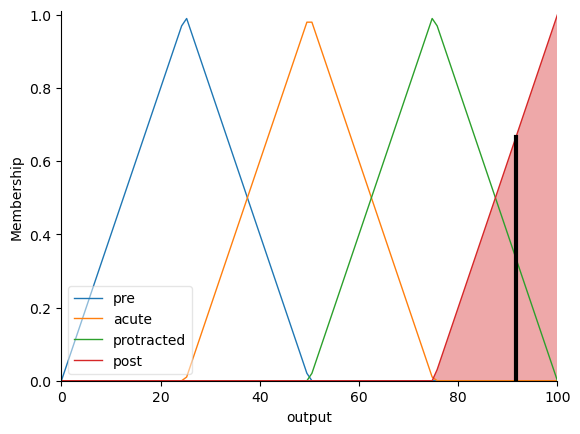

Output value: 91.66161795047296


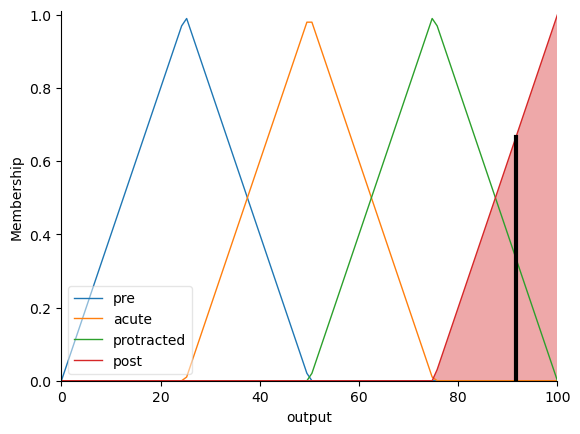

Output value: 91.66161795047296


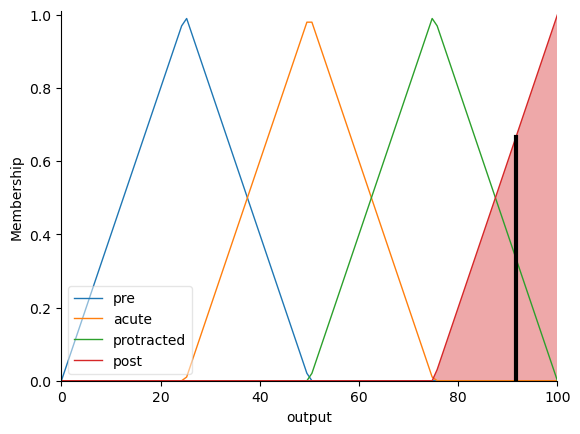

In [13]:
# calling control_sys(rule_pre, rule_acute, rule_protracted, rule_post)
# and calling rules functions (rule_one, two, three and four)
# testing implementation for both control system and all 4x4 rules

# list of rules:
rules = [rule_one,
         rule_two,
         rule_three,
         rule_four]

# for loop to activate each rule:
for rule in rules:
    main = rule()

    # simulate numbers:
    main.input['status'] = 350
    main.input['trend'] = -0.05
    main.input['peak'] = 500

    # main computation:
    main.compute()

    # print output value:
    print("Output value:", main.output['output'])

    # display the image:
    output.view(sim = main)
    plt.show()

In [14]:
def computation(indicator, rule):
    """
    Purpose:
    Perform fuzzy logic computation for a given indicator type and rule set.

    Notes:
    This function applies fuzzy logic rules to each row of a DataFrame (`df`) based on the indicator type
    It computes the output value and category for each row using the specified rule set
    The function returns lists containing the computed output values and categories

    Parameters:
    1. indicator (str): the type of indicator to be processed (Violence, Fatalities...)
    2. rule (function): a function representing the rule set to be applied for computation
    (rule_one, rule_two, rule_three, rule_four ...)

    Returns:
    tuple => a tuple containing two lists:
    - The first list contains the computed output values for each row
    - The second list contains the corresponding output categories
    """
    # main return lists for later:
    out_val = []
    out_cat = []

    # for loop to apply rules within df for each indicator type:
    for index, row in df.iterrows():
        if row["Indicator_name"] == indicator:
            main = rule()
            main.input["status"] = row["Status"]
            main.input["trend"] = row["Trend"]
            main.input["peak"] = row["Peak"]

            # try/except to fetch "Crisp error" when some combination
            # of values for status, trend and peak does not fit any rule group
            try:
                # main computation:
                main.compute()

                # add "Yes" if values passed all rules froom a group:
                df.at[index, "rules_passed"] = 'YES'

                # append values within out_val list:
                out_val.append(main.output["output"])
                

                
                # *************************************
                # can be changed accordingly if needed:
                out_category = ""
            
                if main.output["output"] <= 40:
                    out_category = "pre"
                    
                elif main.output["output"] <= 62:
                    out_category = "acute"
                    
                elif main.output["output"] <= 88:
                    out_category = "protracted"
                    
                elif main.output["output"] <= 100:
                    out_category = "post"
            
                else:
                    pass
                # *************************************

                
                # append categorical names in out_cat:
                out_cat.append(out_category)
                
            # if detected detected error:
            except ValueError as e:
                # assign rule_passed with "No"
                df.at[index, "rules_passed"] = 'No'

                # append NoNe for values and "NA" for all rows:
                out_val.append(np.nan)
                out_cat.append("NA")
        else:
            pass

    return out_val, out_cat

# Test IV (can be excluded to speed up the code)

In [15]:
# check and test function computation(indicator, rule)
# providing specific indicator and rule to follow

# calling the function and applying it in this
# example rule_one on a "Violence" indicator:
one = computation("Number of violent events - ACLED", rule_one)

# clone df before test:
test_df = df.copy()

# apply fetched values from computation function:
test_df.loc[df["Indicator_name"] == "Number of violent events - ACLED", 'Crisis dynamics value'] = one[0]
test_df.loc[df["Indicator_name"] == "Number of violent events - ACLED", 'Crisis dynamics category'] = one[1]

# check df:
test_df.head()

,Region,ISO3,Month_year,Status,Trend,Peak,Indicator_name,rules_passed,Crisis dynamics value,Crisis dynamics category
14,R_ASIA,AFG,2021-03-01,357142.857143,0.0,0.000000,Extreme humanitarian conditions - Level 5,,NaN,NaN
15,R_ASIA,AFG,2021-04-01,428571.428571,0.0,0.000000,Extreme humanitarian conditions - Level 5,,NaN,NaN
16,R_ASIA,AFG,2021-05-01,476190.476190,0.0,0.000000,Extreme humanitarian conditions - Level 5,,NaN,NaN
17,R_ASIA,AFG,2021-06-01,500000.000000,0.0,0.000000,Extreme humanitarian conditions - Level 5,,NaN,NaN
18,R_ASIA,AFG,2021-07-01,500000.000000,0.0,5494.505495,Extreme humanitarian conditions - Level 5,,NaN,NaN


In [16]:
# function for the main setup of dictionary containing
# indicator, rule, indicator value and indicator category
def ind_rule_setup():
    """
    Purpose:
    Set up a dictionary containing indicators, corresponding rules, indicator values, and indicator categories

    Notes:
    This function initializes a dictionary where each key represents an indicator and each value is a list containing:
    - The rule associated with the indicator
    - The value indicating the indicator's value
    - The category indicating the indicator's category

    Parameters:
    None

    Returns:
    dict => a dictionary mapping indicators to their corresponding rule, value, and category
    """

    
    # ***********************************************************************************************************
    # change or add more rules but be warned if new rules are added those rules needs to be also added
    # as a separate ones
    # dictionary containing setup:
    main_dict = {
        # group I (Crisis dynamics):
        "Number of violent events - ACLED": ["rule_one", "Crisis dynamics value", "Crisis dynamics category"],
        "Highly Violent Conflict Probability": ["rule_one", "Crisis dynamics value", "Crisis dynamics category"],
        
        # group II (Severity of the crisis):
        "Fatalities reported": ["rule_two", "Severity of the crisis value", "Severity of the crisis category"],
        "People displaced": ["rule_two", "Severity of the crisis value", "Severity of the crisis category"],
        "Persons held: Rate per 100,000 population": ["rule_two", "Severity of the crisis value", "Severity of the crisis category"],
        # "Missing": ["rule_two", "Severity of the crisis value", "Severity of the crisis category"],
        
        # group III (Scale of the crisis):
        "Minimal humanitarian conditions - Level 1": ["rule_three", "Scale of the crisis value", "Scale of the crisis category"],
        "Stressed humanitarian conditions - Level 2": ["rule_three", "Scale of the crisis value", "Scale of the crisis category"],
        "Moderate humanitarian conditions - Level 3": ["rule_three", "Scale of the crisis value", "Scale of the crisis category"],
        "Severe humanitarian conditions - Level 4": ["rule_three", "Scale of the crisis value", "Scale of the crisis category"],
        "Extreme humanitarian conditions - Level 5": ["rule_three", "Scale of the crisis value", "Scale of the crisis category"]}
        
        # group IV (Projected conflict risk):
        # "Risk of aggravation": ["rule_four", "Projected conflict risk value", "Projected conflict risk category"]}
     # ***********************************************************************************************************

    return main_dict

In [17]:
# function for executing all rules for predefined indicators
def execute_rules():
    """
    Purpose:
    Execute predefined rules for predefined indicators and update a dataframe accordingly

    Notes:
    This function initializes indicator rules using the `ind_rule_setup` function and maps rule names to their corresponding functions
    It iterates over the predefined indicators, applies the associated rule function to each indicator's data in the dataframe,
    and updates the dataframe with the computed values and categories as add columns for each group

    Parameters:
    None

    Returns:
    pandas.DataFrame => the dataframe with updated values and categories after applying the rules
    """
    # calling ind_rule_setup() function:
    irs = ind_rule_setup()


    # ******************************************
    # dict of rule functions for execution
    # if new rules introduced please add
    # here also:
    rule_functions = {"rule_one": rule_one,
                      "rule_two": rule_two,
                      "rule_three": rule_three,
                      "rule_four": rule_four}
    # ******************************************
    

    # for loop within dict:
    for k, v in irs.items():
        rule_function = rule_functions.get(v[0])
        if rule_function is None:
            pass

        # initiate main computation for each row
        # based on predefined variables:
        comp = computation(k, rule_function)

        # add two add columns for each ruling group
        # based on Indicator family:
        df.loc[df["Indicator_name"] == k, v[1]] = comp[0]
        df.loc[df["Indicator_name"] == k, v[2]] = comp[1]

    return df

# Test V

In [18]:
# check and test execute_rules() function:
# call the function:
df = execute_rules()

# show whole df after executing rules:
df.head(10)

,Region,ISO3,Month_year,Status,Trend,Peak,Indicator_name,rules_passed,Crisis dynamics value,Crisis dynamics category,Severity of the crisis value,Severity of the crisis category,Scale of the crisis value,Scale of the crisis category
14,R_ASIA,AFG,2021-03-01,357142.857143,0.0,0.000000,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661606,post
15,R_ASIA,AFG,2021-04-01,428571.428571,0.0,0.000000,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661600,post
16,R_ASIA,AFG,2021-05-01,476190.476190,0.0,0.000000,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661596,post
17,R_ASIA,AFG,2021-06-01,500000.000000,0.0,0.000000,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post
18,R_ASIA,AFG,2021-07-01,500000.000000,0.0,5494.505495,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post
19,R_ASIA,AFG,2021-08-01,500000.000000,0.0,14285.714286,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post
20,R_ASIA,AFG,2021-09-01,500000.000000,0.0,25000.000000,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post
21,R_ASIA,AFG,2021-10-01,500000.000000,0.0,36764.705882,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post
22,R_ASIA,AFG,2021-11-01,500000.000000,0.0,49019.607843,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post
23,R_ASIA,AFG,2021-12-01,500000.000000,0.0,61403.508772,Extreme humanitarian conditions - Level 5,YES,NaN,NaN,NaN,NaN,91.661594,post


In [19]:
# function to save data in .csv or .xlsx:
def save_file(file_name, format):
    """
    Purpose:
    Function to save a dataframe to a file in either .csv or .xlsx format

    Parameters:
    1. file_name (str): the filename for the output file
    2. format (int): an integer indicating the format to save the file
    - 0: save as .csv format
    - 1: save as .xlsx format
    
    Returns:
    None
    """
    if format == 0:
        df.to_csv(file_name + ".csv",
                  index = False)
    elif format == 1:
        df.to_excel(file_name + ".xlsx",
                    index = False)
    else:
        print("Either wrong file_name or format or both!")

In [20]:
# call the function => save_file(file_name, format)


# **************************
# change name of the output
# file and specify format
# change this only once!:
save_file("final_output", 1)
# **************************